# MLDL2 Homework : Semi-Supervised Learning & Self-Supervised Learning

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from torchsummary import summary
from torchsummary import summary
import torchvision.transforms.functional as TF
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Dataset

In [20]:
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy # for augmenting data

# Define training augmentations
train_transform = transforms.Compose([
    transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


val_transform2 = transforms.Compose([
  transforms.ToPILImage(),
   transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

BATCH_SIZE = 8


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/mldl2/MLDL2_HW")

Mounted at /content/gdrive


## **Do not modify the cell below!!!!**


In [21]:
train_dataset = datasets.CIFAR10(root="./data/",
                                 train=True,
                                 download=True,
                                transform=train_transform
                                 )

val_dataset = datasets.CIFAR10(root="./data/",
                                train=False,
                                download=True,
                                 transform=train_transform
                                )

num_labeled = 5000
num_unlabeled = len(train_dataset) - num_labeled

indices = list(range(len(train_dataset)))
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

for idx in unlabeled_indices:
    train_dataset.targets[idx] = -1

labeled_train_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
unlabeled_train_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

labeled_train_loader = torch.utils.data.DataLoader(dataset=labeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

unlabeled_train_loader = torch.utils.data.DataLoader(dataset=unlabeled_train_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
class val_Dataset2(Dataset):
    def __init__(self,img_file, label_file, transform=None):
        self.img =np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image,label

In [23]:
val_dataset2 = val_Dataset2(img_file="./valid_dataset2.npy",label_file="./valid_dataset2_label.npy",transform=val_transform2)
val_loader2 = torch.utils.data.DataLoader(val_dataset2, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [24]:
print("labeled_train_dataset size : ", len(labeled_train_dataset))
print("unlabeled_train_dataset size : ", len(unlabeled_train_dataset))
print("val_dataset size : ", len(val_dataset))
print("val_dataset2 size : ", len(val_dataset2))

labeled_train_dataset size :  5000
unlabeled_train_dataset size :  45000
val_dataset size :  10000
val_dataset2 size :  9500


In [8]:
temp = [0]*10
for i in range(5000):
  temp[labeled_train_dataset[i][-1]] = temp[labeled_train_dataset[i][-1]] + 1

In [9]:
temp

[505, 460, 519, 486, 519, 488, 519, 486, 520, 498]

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler. Below is very simple model with CNN. You can customize your own model and note that you are not limited to use any methods. **But you are not allowed to use pretrained weight**

In [11]:
lambda_u = 75.0
num_epochs=50

In [25]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define ResNet18 as base model
        resnet = resnet18(pretrained=False)
        self.resnet_layers = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers

        # Add your custom layers
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet_layers(x)
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [27]:
model = Net()
# 모델 인스턴스 생성
# model = CustomMobileNet()
model.to(device)

Net(
  (resnet_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [29]:
from copy import deepcopy
from itertools import cycle
train_losses = []
val_losses1 = []
val_losses2=[]

train_acc = []
val_acc1 = []
val_acc2=[]
ema_alpha = 0.99  # EMA decay factor
consistency_criterion = F.mse_loss  # Mean Squared Error loss
consistency_weight = 1
# Create a cyclic iterator for the labeled dataset
labeled_iter = cycle(labeled_train_loader)
best_val_accuracy = 0.0  # Track the best validation accuracy
early_stopping_counter = 0  # Initialize counter for early stopping
patience = 5  # Patience for early stopping
# Initialize the teacher model
teacher_model = deepcopy(model).to(device)

for epoch in range(num_epochs):
    total_loss_labeled = 0.0
    correct_predictions_labeled = 0
    total_samples_labeled = 0

    for unlabeled_data in tqdm(unlabeled_train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        #Handle labeled data
        labeled_data = next(labeled_iter)
        inputs_l, labels_l = labeled_data
        inputs_l, labels_l = inputs_l.to(device), labels_l.to(device)

        optimizer.zero_grad()

        # Update teacher model (EMA)
        for param, ema_param in zip(model.parameters(), teacher_model.parameters()):
            ema_param.data.mul_(ema_alpha).add_((1.0 - ema_alpha) * param.data)

        #레이블 데이타의 경우는 cross entropy loss
        outputs_l = model(inputs_l)
        loss_l = criterion(outputs_l, labels_l)
        total_loss_labeled += loss_l.item()
        _, predicted_labels_l = torch.max(outputs_l, 1)
        correct_predictions_labeled += (predicted_labels_l == labels_l).sum().item()
        total_samples_labeled += labels_l.size(0)

        # Handle unlabeled data
        inputs_u, _ = unlabeled_data
        inputs_u = inputs_u.to(device)

        outputs_u = model(inputs_u)
        #수도 레이블 만들기
        pseudo_labels = torch.argmax(outputs_u, dim=1)

        # Consistency regularization
        with torch.no_grad():
            teacher_outputs_u = teacher_model(inputs_u)
            #mse loss사용
            consistency_loss = consistency_criterion(outputs_u, teacher_outputs_u)

        # Sample the same number of unlabeled samples as labeled samples
        indices = torch.randperm(inputs_u.size(0))[:inputs_l.size(0)]
        inputs_u = inputs_u[indices]
        pseudo_labels = pseudo_labels[indices]

        # Combine labeled and pseudo-labeled data for loss calculation
        combined_inputs = torch.cat((inputs_l, inputs_u), dim=0)
        combined_labels = torch.cat((labels_l, pseudo_labels), dim=0)
        #combined loss backprop
        optimizer.zero_grad()
        outputs_combined = model(combined_inputs)
        # print(criterion(outputs_combined, combined_labels) ,consistency_loss)
        loss_combined = criterion(outputs_combined, combined_labels) + consistency_weight * consistency_loss
        loss_combined.backward()
        optimizer.step()

    # Update the EMA parameters of the teacher model at the end of each epoch
    for param, ema_param in zip(model.parameters(), teacher_model.parameters()):
        ema_param.data.copy_(param.data)

    average_loss_labeled = total_loss_labeled / len(labeled_train_loader.dataset)
    train_losses.append(average_loss_labeled)

    accuracy_labeled = correct_predictions_labeled / total_samples_labeled * 100
    train_acc.append(accuracy_labeled)
    print(f'Training - Epoch {epoch + 1}/{num_epochs}, Labeled Data - Average Loss: {average_loss_labeled}, Accuracy: {accuracy_labeled:.2f}%')
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
     # Validation loop for val_dataset1

    with torch.no_grad():
        for val_data in val_loader:
            inputs_val, labels_val = val_data
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)
            #validation은 evaluate용이기 때문에 mse가 아닌 crossentropy loss적용
            loss_val = criterion(outputs_val, labels_val)
            val_loss += loss_val.item()

            _, predicted_labels_val = torch.max(outputs_val, 1)
            val_correct_predictions += (predicted_labels_val == labels_val).sum().item()
            val_total_samples += labels_val.size(0)

    average_val_loss = val_loss / len(val_loader.dataset)
    val_losses1.append(average_val_loss)
    val_accuracy = val_correct_predictions / val_total_samples * 100
    val_acc1.append(val_accuracy)
    #Validation loop for val_dataset2
    val_loss2 = 0.0
    val_correct_predictions2 = 0
    val_total_samples2 = 0

    with torch.no_grad():
        for val_data2 in val_loader2:
            inputs_val2, labels_val2 = val_data2
            inputs_val2, labels_val2 = inputs_val2.to(device), labels_val2.to(device)

            outputs_val2 = model(inputs_val2)
            loss_val2 = criterion(outputs_val2, labels_val2)
            val_loss2 += loss_val2.item()

            _, predicted_labels_val2 = torch.max(outputs_val2, 1)
            val_correct_predictions2 += (predicted_labels_val2 == labels_val2).sum().item()
            val_total_samples2 += labels_val2.size(0)


    average_val_loss2 = val_loss2 / len(val_loader2.dataset)
    val_losses2.append(average_val_loss2)
    val_accuracy2 = val_correct_predictions2 / val_total_samples2 * 100
    val_acc2.append(val_accuracy2)
    val_accuracy=(val_accuracy2+val_accuracy)/2
    print(f'Validation - Epoch {epoch + 1}/{num_epochs},  Accuracy: {val_accuracy:.2f}%')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/mldl2/MLDL2_HW/semi_best_model.pth')
    else:
      # 최고 검증 정확도가 갱신되지 않으면 조기 종료 카운터를 증가시킵니다.
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"No improvement in validation accuracy for {patience} epochs. Early stopping...")
            break  # Stop training


Epoch 1/50: 100%|██████████| 5625/5625 [02:42<00:00, 34.54it/s]


Training - Epoch 1/50, Labeled Data - Average Loss: 2.4790462924957275, Accuracy: 17.66%
Validation - Epoch 1/50,  Accuracy: 32.09%


Epoch 2/50: 100%|██████████| 5625/5625 [02:27<00:00, 38.08it/s]


Training - Epoch 2/50, Labeled Data - Average Loss: 1.4179064218916, Accuracy: 57.63%
Validation - Epoch 2/50,  Accuracy: 44.15%


Epoch 3/50: 100%|██████████| 5625/5625 [02:25<00:00, 38.64it/s]


Training - Epoch 3/50, Labeled Data - Average Loss: 0.7965172659895383, Accuracy: 77.87%
Validation - Epoch 3/50,  Accuracy: 43.66%


Epoch 4/50: 100%|██████████| 5625/5625 [02:27<00:00, 38.17it/s]


Training - Epoch 4/50, Labeled Data - Average Loss: 0.5013538106373511, Accuracy: 86.66%
Validation - Epoch 4/50,  Accuracy: 46.12%


Epoch 5/50: 100%|██████████| 5625/5625 [02:29<00:00, 37.61it/s]


Training - Epoch 5/50, Labeled Data - Average Loss: 0.3449353693897836, Accuracy: 91.10%
Validation - Epoch 5/50,  Accuracy: 46.28%


Epoch 6/50: 100%|██████████| 5625/5625 [02:33<00:00, 36.59it/s]


Training - Epoch 6/50, Labeled Data - Average Loss: 0.28471065667972434, Accuracy: 92.87%
Validation - Epoch 6/50,  Accuracy: 47.92%


Epoch 7/50: 100%|██████████| 5625/5625 [02:29<00:00, 37.56it/s]


Training - Epoch 7/50, Labeled Data - Average Loss: 0.25253495187364167, Accuracy: 93.86%
Validation - Epoch 7/50,  Accuracy: 47.81%


Epoch 8/50: 100%|██████████| 5625/5625 [02:29<00:00, 37.65it/s]


Training - Epoch 8/50, Labeled Data - Average Loss: 0.21060919337813103, Accuracy: 95.03%
Validation - Epoch 8/50,  Accuracy: 48.34%


Epoch 9/50: 100%|██████████| 5625/5625 [02:26<00:00, 38.45it/s]


Training - Epoch 9/50, Labeled Data - Average Loss: 0.18952732255064839, Accuracy: 95.58%
Validation - Epoch 9/50,  Accuracy: 47.89%


Epoch 10/50: 100%|██████████| 5625/5625 [02:24<00:00, 38.86it/s]


Training - Epoch 10/50, Labeled Data - Average Loss: 0.16957034800788534, Accuracy: 96.07%
Validation - Epoch 10/50,  Accuracy: 47.90%


Epoch 11/50: 100%|██████████| 5625/5625 [02:26<00:00, 38.38it/s]


Training - Epoch 11/50, Labeled Data - Average Loss: 0.1700125508384648, Accuracy: 96.15%
Validation - Epoch 11/50,  Accuracy: 47.97%


Epoch 12/50: 100%|██████████| 5625/5625 [02:26<00:00, 38.28it/s]


Training - Epoch 12/50, Labeled Data - Average Loss: 0.15416966727042783, Accuracy: 96.51%
Validation - Epoch 12/50,  Accuracy: 45.48%


Epoch 13/50: 100%|██████████| 5625/5625 [02:26<00:00, 38.46it/s]


Training - Epoch 13/50, Labeled Data - Average Loss: 0.14866263759557186, Accuracy: 96.62%
Validation - Epoch 13/50,  Accuracy: 47.30%
No improvement in validation accuracy for 5 epochs. Early stopping...


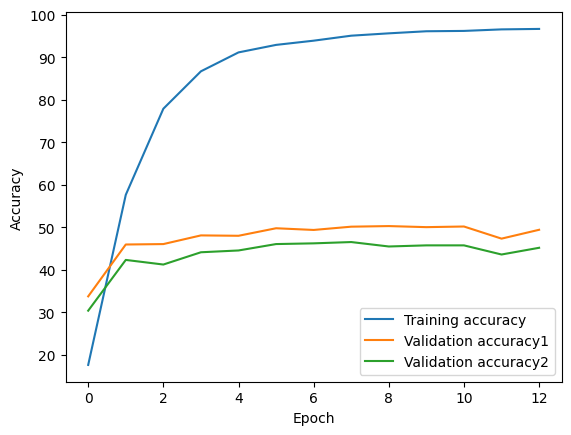

In [31]:
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc1, label='Validation accuracy1')
plt.plot(val_acc2, label='Validation accuracy2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

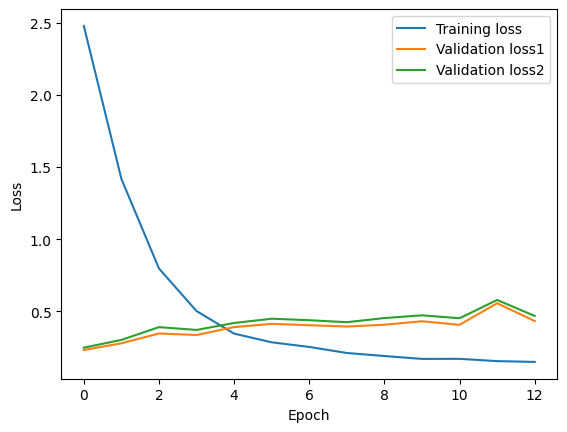

In [32]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses1, label='Validation loss1')
plt.plot(val_losses2, label='Validation loss2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
pt_path="/content/gdrive/MyDrive/mldl2/MLDL2_HW/semi_best_model.pth"
model = Net()
model.load_state_dict(torch.load(pt_path))
model.to(device)
val_correct_predictions2=0
val_loss2=0
with torch.no_grad():
    for val_data2 in val_loader:
            inputs_val2, labels_val2 = val_data2
            inputs_val2, labels_val2 = inputs_val2.to(device), labels_val2.to(device)
            outputs_val2 = model(inputs_val2)
            loss_val2 = criterion(outputs_val2, labels_val2)
            val_loss2 += loss_val2.item()
            _, predicted_labels_val2 = torch.max(outputs_val2, 1)
            val_correct_predictions2 += (predicted_labels_val2 == labels_val2).sum().item()
val_accuracy2 = val_correct_predictions2 / val_total_samples2 * 100
print(val_accuracy2)

45.252631578947366


In [75]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)

        return image
test_dataset = TestDataset(img_file="./test_data.npy",transform=val_transform2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
def test(model, test_loader):
  model.eval()

  ### List to store predictions
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):

          data = data.float().to(device)
          output = model(data)
          ### Get most likely predicted  with argmax
          predicted_labels = torch.argmax(output, dim=1)

          test_predictions.extend(predicted_labels.cpu().tolist())

  return test_predictions
predictions = test(model, test_loader)
### Create CSV file with predictions
saved_path="2019-17577_정지후_semi_HW3.csv"
with open(saved_path, "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))


100%|██████████| 119/119 [00:00<00:00, 194.05it/s]


# **Self-Supervised Learning**
https://github.com/p3i0t/SimCLR-CIFAR10/tree/master 이 모델 참고했다.

In [36]:
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.models import resnet18, resnet34
from torchvision import transforms

from tqdm import tqdm
import torch.nn as nn


class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        #base encoder모델 pretrained없이 불러오기
        self.enc = base_encoder(pretrained=False)
        self.feature_dim = self.enc.fc.in_features
        # Customize SimCLR for CIFAR10.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()
        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
      # 현재 값 및 누적값 갱신 메서드
        # val: 현재 값
        # n: 값의 개수 (기본값은 1)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count # 새로운 평균 계산


#noise-contrastive loss
def nt_xent(x, t=0.5):
   # 입력 텐서 정규화
    x = F.normalize(x, dim=1)
    x_scores =  (x @ x.t()).clamp(min=1e-7)
    # temparature 적용하여 스케일 조정
    x_scale = x_scores / t
    # 대각선 항을 큰 음수 값으로 대체
    x_scale = x_scale - torch.eye(x_scale.size(0)).to(x_scale.device) * 1e5
    # 대조 대상 생성
    targets = torch.arange(x.size()[0])

    targets[::2] += 1
    targets[1::2] -= 1
    return F.cross_entropy(x_scale, targets.long().to(x_scale.device))


def get_lr(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

def get_color_distortion(s=0.5):  # 0.5 for CIFAR10 by default
    # s is the strength of color distortion
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

data_dir = "./data"

# model
backbone = "resnet18"
projection_dim = 128
seed = 42
batch_size = 512
workers = 16
epochs = 10
log_interval = 50

# loss options
optimizer = 'sgd'
learning_rate = 0.2
momentum = 0.9
weight_decay = 1.0e-6
temperature = 0.5

# finetune options
finetune_epochs = 100
load_epoch = 1000


def train(train_loader) -> None:

    assert backbone in ['resnet18', 'resnet34']
    base_encoder = eval(backbone)
    model = SimCLR(base_encoder, projection_dim=projection_dim).cuda()

    optimizer = torch.optim.SGD(
        model.parameters(),
        learning_rate,
        momentum=momentum,
        weight_decay=weight_decay,
        nesterov=True)

    scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
            step,
            epochs * len(train_loader),
            learning_rate,  # lr_lambda computes multiplicative factor
            1e-3))


    model.train()
    for epoch in range(1, epochs + 1):
        loss_meter = AverageMeter("SimCLR_loss")
        train_bar = tqdm(train_loader)
        for x, y in train_bar:
            #train 시작 for unlabeled data
            sizes = x.size()
            x = x.view(sizes[0] * 2, sizes[2], sizes[3], sizes[4]).cuda(non_blocking=True)

            optimizer.zero_grad()
            feature, rep = model(x)
            #loss 계산
            loss = nt_xent(rep, temperature)
            loss.backward()
            #gradient clipping for prevent exploding gradinet
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            loss_meter.update(loss.item(), x.size(0))
            train_bar.set_description("Train epoch {}, SimCLR loss: {:.4f}".format(epoch, loss_meter.avg))

        # save checkpoint very log_interval epochs
        if epoch >= 10 and epoch % 10 == 0:
            checkpoint_path = '/content/gdrive/MyDrive/mldl2/MLDL2_HW/simclr_{}_epoch{}.pt'.format(backbone, epoch)
            torch.save(model.state_dict(), checkpoint_path)
            print("==> Saved checkpoint. Train epoch {}, Model saved at: {}".format(epoch, checkpoint_path))


In [39]:
transform1 = transforms.Compose([transforms.RandomResizedCrop(32),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          get_color_distortion(s=0.5),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                          ])

transform2 = transforms.Compose([transforms.RandomResizedCrop(32),
                                 get_color_distortion(s=0.5),
                                  transforms.RandomHorizontalFlip(p=0.3),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                      ])

class DoubleTransform(Dataset):
    def __init__(self, dataset, transform1, transform2):
        self.dataset = dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __getitem__(self, idx):
        img, target = self.dataset[idx][0], self.dataset[idx][1]
        img1 = self.transform1(img)
        img2 = self.transform2(img)
        imgs = [img1, img2]
        return torch.stack(imgs), target
    def __len__(self):
        return len(self.dataset)
#unlabeled_train_dataset 사용
double_transform = DoubleTransform(unlabeled_train_dataset, transform1, transform2)

# DataLoader 설정
train_loader = DataLoader(
    double_transform,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    drop_last=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [40]:
train(train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/87 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for 

==> Saved checkpoint. Train epoch 10, Model saved at: /content/gdrive/MyDrive/mldl2/MLDL2_HW/simclr_resnet18_epoch10.pt


In [54]:
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision.models import resnet18, resnet34

from tqdm import tqdm



class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class LinModel(nn.Module):
    """Linear wrapper of encoder."""
    def __init__(self, encoder: nn.Module, feature_dim: int, n_classes: int):
        super().__init__()
        self.enc = encoder
        self.feature_dim = feature_dim
        self.n_classes = n_classes
        self.lin = nn.Linear(self.feature_dim, self.n_classes)

    def forward(self, x):
        return self.lin(self.enc(x))


def run_epoch(model, dataloader, epoch, optimizer=None, scheduler=None):
  # 옵티마이저가 주어지면 학습 모드로, 그렇지 않으면 평가 모드로 설정합니다.

    if optimizer:
        model.train()
    else:
        model.eval()
    #loss, accuracy function 설정
    loss_meter = AverageMeter('loss')
    acc_meter = AverageMeter('acc')
    loader_bar = tqdm(dataloader)
    for x, y in loader_bar:
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        # CrossEntropy 손실 계산
        loss = F.cross_entropy(logits, y)
      # 학습 중일 때는 loss backward
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
        #정확도 계산
        acc = (logits.argmax(dim=1) == y).float().mean()
        # AverageMeter를 사용하여 손실 및 정확도 업데이트
        loss_meter.update(loss.item(), x.size(0))
        acc_meter.update(acc.item(), x.size(0))
        if optimizer:
            loader_bar.set_description("Train epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))
        else:
            loader_bar.set_description("Test epoch {}, loss: {:.4f}, acc: {:.4f}"
                                       .format(epoch, loss_meter.avg, acc_meter.avg))
    return loss_meter.avg, acc_meter.avg


def get_lr(step, total_steps, lr_max, lr_min):
    print("total_steps",total_steps)
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

train_losses = []
val_losses1 = []
val_losses2=[]

train_accs = []
val_acc1 = []
val_acc2=[]
best_val_accuracy = 0.0  # Track the best validation accuracy
early_stopping_counter = 0  # Initialize counter for early stopping
patience = 5  # Patience for early stopping

pt_path="/content/gdrive/MyDrive/mldl2/MLDL2_HW/simclr_resnet18_epoch10.pt"
def finetune() -> None:
    #finetuning with labeled_train_dataset
    train_set = labeled_train_dataset
    n_classes = 10
    train_loader = DataLoader(train_set, batch_size=batch_size, drop_last=True)

    # Prepare model
    base_encoder = eval(backbone)
    pre_model = SimCLR(base_encoder, projection_dim=projection_dim).cuda()

    pre_model.load_state_dict(torch.load(pt_path))
    #linear model도 준비
    model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=10)
    model = model.cuda()

    model.enc.requires_grad = False
    parameters = [param for param in model.parameters() if param.requires_grad is True]  # trainable parameters.

    optimizer = torch.optim.SGD(
        parameters,
        0.2,
        momentum=momentum,
        weight_decay=0.,
        nesterov=True)

    scheduler = LambdaLR(
        optimizer,

        lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
            step,
            epochs * len(train_loader),
            learning_rate,  # lr_lambda computes multiplicative factor
            1e-3))

    optimal_loss, optimal_acc = 1e5, 0.
    best_val_accuracy=0
    #train,validation loss 계산
    for epoch in range(1, finetune_epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, epoch, optimizer, scheduler)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_loss, test_acc = run_epoch(model, val_loader, epoch)
        test_loss2, test_acc2 = run_epoch(model, val_loader2, epoch)
        val_losses1.append(test_loss)
        val_losses2.append(test_loss2)
        val_acc1.append(test_acc)
        val_acc2.append(test_acc2)

        val_accuracy= (test_acc+test_acc2)/2
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
            torch.save(model.state_dict(), '/content/gdrive/MyDrive/mldl2/MLDL2_HW/self_best_model.pth')
        else:
          # 최고 검증 정확도가 갱신되지 않으면 조기 종료 카운터를 증가시킵니다.
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"No improvement in validation accuracy for {patience} epochs. Early stopping...")
                break  # Stop training
    # logger.info("Best Test Acc: {:.4f}".format(optimal_acc))

In [55]:
finetune()

total_steps 90


  0%|          | 0/9 [00:00<?, ?it/s]

total_steps 90


Train epoch 1, loss: 2.6310, acc: 0.1230:  22%|██▏       | 2/9 [00:00<00:01,  3.69it/s]

total_steps 90


Train epoch 1, loss: 2.5354, acc: 0.1595:  33%|███▎      | 3/9 [00:00<00:01,  3.75it/s]

total_steps 90


Train epoch 1, loss: 2.4941, acc: 0.1831:  44%|████▍     | 4/9 [00:01<00:01,  3.72it/s]

total_steps 90


Train epoch 1, loss: 2.4815, acc: 0.1918:  56%|█████▌    | 5/9 [00:01<00:01,  3.71it/s]

total_steps 90


Train epoch 1, loss: 2.4874, acc: 0.2100:  67%|██████▋   | 6/9 [00:01<00:00,  3.76it/s]

total_steps 90


Train epoch 1, loss: 2.4447, acc: 0.2243:  78%|███████▊  | 7/9 [00:01<00:00,  3.77it/s]

total_steps 90


Train epoch 1, loss: 2.3745, acc: 0.2363:  89%|████████▉ | 8/9 [00:02<00:00,  3.77it/s]

total_steps 90


Train epoch 1, loss: 2.3384, acc: 0.2530: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


total_steps 90


Train epoch 2, loss: 1.6949, acc: 0.3965:  11%|█         | 1/9 [00:00<00:02,  3.49it/s]

total_steps 90


Train epoch 2, loss: 1.7149, acc: 0.3848:  22%|██▏       | 2/9 [00:00<00:01,  3.61it/s]

total_steps 90


Train epoch 2, loss: 1.6569, acc: 0.3984:  33%|███▎      | 3/9 [00:00<00:01,  3.66it/s]

total_steps 90


Train epoch 2, loss: 1.6377, acc: 0.4023:  44%|████▍     | 4/9 [00:01<00:01,  3.74it/s]

total_steps 90


Train epoch 2, loss: 1.6095, acc: 0.4148:  56%|█████▌    | 5/9 [00:01<00:01,  3.78it/s]

total_steps 90


Train epoch 2, loss: 1.5911, acc: 0.4186:  67%|██████▋   | 6/9 [00:01<00:00,  3.70it/s]

total_steps 90


Train epoch 2, loss: 1.6033, acc: 0.4238:  78%|███████▊  | 7/9 [00:01<00:00,  3.76it/s]

total_steps 90


Train epoch 2, loss: 1.5963, acc: 0.4255:  89%|████████▉ | 8/9 [00:02<00:00,  3.76it/s]

total_steps 90


Train epoch 2, loss: 1.5863, acc: 0.4314: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


total_steps 90


Train epoch 3, loss: 1.5346, acc: 0.4727:  11%|█         | 1/9 [00:00<00:02,  3.57it/s]

total_steps 90


Train epoch 3, loss: 1.4225, acc: 0.4873:  22%|██▏       | 2/9 [00:00<00:01,  3.66it/s]

total_steps 90


Train epoch 3, loss: 1.3541, acc: 0.5052:  33%|███▎      | 3/9 [00:00<00:01,  3.64it/s]

total_steps 90


Train epoch 3, loss: 1.3228, acc: 0.5259:  44%|████▍     | 4/9 [00:01<00:01,  3.68it/s]

total_steps 90


Train epoch 3, loss: 1.2900, acc: 0.5387:  56%|█████▌    | 5/9 [00:01<00:01,  3.65it/s]

total_steps 90


Train epoch 3, loss: 1.2739, acc: 0.5492:  67%|██████▋   | 6/9 [00:01<00:00,  3.67it/s]

total_steps 90


Train epoch 3, loss: 1.2659, acc: 0.5497:  78%|███████▊  | 7/9 [00:01<00:00,  3.63it/s]

total_steps 90


Train epoch 3, loss: 1.2440, acc: 0.5557:  89%|████████▉ | 8/9 [00:02<00:00,  3.65it/s]

total_steps 90


Train epoch 3, loss: 1.2279, acc: 0.5608: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


total_steps 90


Train epoch 4, loss: 1.0739, acc: 0.6074:  11%|█         | 1/9 [00:00<00:02,  3.45it/s]

total_steps 90


Train epoch 4, loss: 1.0546, acc: 0.6104:  22%|██▏       | 2/9 [00:00<00:01,  3.63it/s]

total_steps 90


Train epoch 4, loss: 1.0210, acc: 0.6270:  33%|███▎      | 3/9 [00:00<00:01,  3.67it/s]

total_steps 90


Train epoch 4, loss: 1.0139, acc: 0.6377:  44%|████▍     | 4/9 [00:01<00:01,  3.61it/s]

total_steps 90


Train epoch 4, loss: 0.9966, acc: 0.6449:  56%|█████▌    | 5/9 [00:01<00:01,  3.59it/s]

total_steps 90


Train epoch 4, loss: 0.9889, acc: 0.6504:  67%|██████▋   | 6/9 [00:01<00:00,  3.53it/s]

total_steps 90


Train epoch 4, loss: 0.9845, acc: 0.6549:  78%|███████▊  | 7/9 [00:01<00:00,  3.53it/s]

total_steps 90


Train epoch 4, loss: 0.9667, acc: 0.6616:  89%|████████▉ | 8/9 [00:02<00:00,  3.49it/s]

total_steps 90


Train epoch 4, loss: 0.9556, acc: 0.6656: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


total_steps 90


Train epoch 5, loss: 0.8420, acc: 0.7012:  11%|█         | 1/9 [00:00<00:02,  3.32it/s]

total_steps 90


Train epoch 5, loss: 0.8325, acc: 0.7061:  22%|██▏       | 2/9 [00:00<00:02,  3.49it/s]

total_steps 90


Train epoch 5, loss: 0.8030, acc: 0.7266:  33%|███▎      | 3/9 [00:00<00:01,  3.63it/s]

total_steps 90


Train epoch 5, loss: 0.7988, acc: 0.7363:  44%|████▍     | 4/9 [00:01<00:01,  3.69it/s]

total_steps 90


Train epoch 5, loss: 0.7836, acc: 0.7438:  56%|█████▌    | 5/9 [00:01<00:01,  3.71it/s]

total_steps 90


Train epoch 5, loss: 0.7736, acc: 0.7477:  67%|██████▋   | 6/9 [00:01<00:00,  3.75it/s]

total_steps 90


Train epoch 5, loss: 0.7673, acc: 0.7539:  78%|███████▊  | 7/9 [00:01<00:00,  3.80it/s]

total_steps 90


Train epoch 5, loss: 0.7500, acc: 0.7615:  89%|████████▉ | 8/9 [00:02<00:00,  3.78it/s]

total_steps 90


Train epoch 5, loss: 0.7387, acc: 0.7676: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


total_steps 90


Train epoch 6, loss: 0.6166, acc: 0.8242:  11%|█         | 1/9 [00:00<00:02,  3.46it/s]

total_steps 90


Train epoch 6, loss: 0.6181, acc: 0.8223:  22%|██▏       | 2/9 [00:00<00:01,  3.52it/s]

total_steps 90


Train epoch 6, loss: 0.5958, acc: 0.8294:  33%|███▎      | 3/9 [00:00<00:01,  3.60it/s]

total_steps 90


Train epoch 6, loss: 0.5927, acc: 0.8345:  44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]

total_steps 90


Train epoch 6, loss: 0.5800, acc: 0.8375:  56%|█████▌    | 5/9 [00:01<00:01,  3.65it/s]

total_steps 90


Train epoch 6, loss: 0.5718, acc: 0.8418:  67%|██████▋   | 6/9 [00:01<00:00,  3.58it/s]

total_steps 90


Train epoch 6, loss: 0.5678, acc: 0.8440:  78%|███████▊  | 7/9 [00:01<00:00,  3.59it/s]

total_steps 90


Train epoch 6, loss: 0.5546, acc: 0.8486:  89%|████████▉ | 8/9 [00:02<00:00,  3.65it/s]

total_steps 90


Train epoch 6, loss: 0.5443, acc: 0.8535: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


total_steps 90


Train epoch 7, loss: 0.4301, acc: 0.8926:  11%|█         | 1/9 [00:00<00:02,  3.72it/s]

total_steps 90


Train epoch 7, loss: 0.4449, acc: 0.8838:  22%|██▏       | 2/9 [00:00<00:01,  3.65it/s]

total_steps 90


Train epoch 7, loss: 0.4360, acc: 0.8926:  33%|███▎      | 3/9 [00:00<00:01,  3.72it/s]

total_steps 90


Train epoch 7, loss: 0.4336, acc: 0.8965:  44%|████▍     | 4/9 [00:01<00:01,  3.75it/s]

total_steps 90


Train epoch 7, loss: 0.4250, acc: 0.9027:  56%|█████▌    | 5/9 [00:01<00:01,  3.73it/s]

total_steps 90


Train epoch 7, loss: 0.4209, acc: 0.9043:  67%|██████▋   | 6/9 [00:01<00:00,  3.75it/s]

total_steps 90


Train epoch 7, loss: 0.4190, acc: 0.9060:  78%|███████▊  | 7/9 [00:01<00:00,  3.75it/s]

total_steps 90


Train epoch 7, loss: 0.4119, acc: 0.9077:  89%|████████▉ | 8/9 [00:02<00:00,  3.65it/s]

total_steps 90


Train epoch 7, loss: 0.4054, acc: 0.9123: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


total_steps 90


Train epoch 8, loss: 0.3370, acc: 0.9414:  11%|█         | 1/9 [00:00<00:02,  3.54it/s]

total_steps 90


Train epoch 8, loss: 0.3400, acc: 0.9365:  22%|██▏       | 2/9 [00:00<00:01,  3.66it/s]

total_steps 90


Train epoch 8, loss: 0.3347, acc: 0.9388:  33%|███▎      | 3/9 [00:00<00:01,  3.70it/s]

total_steps 90


Train epoch 8, loss: 0.3379, acc: 0.9365:  44%|████▍     | 4/9 [00:01<00:01,  3.74it/s]

total_steps 90


Train epoch 8, loss: 0.3331, acc: 0.9395:  56%|█████▌    | 5/9 [00:01<00:01,  3.78it/s]

total_steps 90


Train epoch 8, loss: 0.3340, acc: 0.9395:  67%|██████▋   | 6/9 [00:01<00:00,  3.78it/s]

total_steps 90


Train epoch 8, loss: 0.3336, acc: 0.9397:  78%|███████▊  | 7/9 [00:01<00:00,  3.81it/s]

total_steps 90


Train epoch 8, loss: 0.3278, acc: 0.9421:  89%|████████▉ | 8/9 [00:02<00:00,  3.81it/s]

total_steps 90


Train epoch 8, loss: 0.3233, acc: 0.9442: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


total_steps 90


Train epoch 9, loss: 0.2677, acc: 0.9609:  11%|█         | 1/9 [00:00<00:02,  3.37it/s]

total_steps 90


Train epoch 9, loss: 0.2723, acc: 0.9600:  22%|██▏       | 2/9 [00:00<00:02,  3.49it/s]

total_steps 90


Train epoch 9, loss: 0.2720, acc: 0.9616:  33%|███▎      | 3/9 [00:00<00:01,  3.54it/s]

total_steps 90


Train epoch 9, loss: 0.2796, acc: 0.9585:  44%|████▍     | 4/9 [00:01<00:01,  3.61it/s]

total_steps 90


Train epoch 9, loss: 0.2768, acc: 0.9598:  56%|█████▌    | 5/9 [00:01<00:01,  3.69it/s]

total_steps 90


Train epoch 9, loss: 0.2742, acc: 0.9616:  67%|██████▋   | 6/9 [00:01<00:00,  3.75it/s]

total_steps 90


Train epoch 9, loss: 0.2735, acc: 0.9623:  78%|███████▊  | 7/9 [00:01<00:00,  3.78it/s]

total_steps 90


Train epoch 9, loss: 0.2692, acc: 0.9648:  89%|████████▉ | 8/9 [00:02<00:00,  3.79it/s]

total_steps 90


Train epoch 9, loss: 0.2663, acc: 0.9661: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


total_steps 90


Train epoch 10, loss: 0.2339, acc: 0.9785:  11%|█         | 1/9 [00:00<00:02,  3.64it/s]

total_steps 90


Train epoch 10, loss: 0.2374, acc: 0.9756:  22%|██▏       | 2/9 [00:00<00:01,  3.70it/s]

total_steps 90


Train epoch 10, loss: 0.2313, acc: 0.9772:  33%|███▎      | 3/9 [00:00<00:01,  3.75it/s]

total_steps 90


Train epoch 10, loss: 0.2362, acc: 0.9727:  44%|████▍     | 4/9 [00:01<00:01,  3.77it/s]

total_steps 90


Train epoch 10, loss: 0.2360, acc: 0.9727:  56%|█████▌    | 5/9 [00:01<00:01,  3.76it/s]

total_steps 90


Train epoch 10, loss: 0.2375, acc: 0.9736:  67%|██████▋   | 6/9 [00:01<00:00,  3.76it/s]

total_steps 90


Train epoch 10, loss: 0.2398, acc: 0.9738:  78%|███████▊  | 7/9 [00:01<00:00,  3.75it/s]

total_steps 90


Train epoch 10, loss: 0.2373, acc: 0.9761:  89%|████████▉ | 8/9 [00:02<00:00,  3.71it/s]

total_steps 90


Train epoch 10, loss: 0.2362, acc: 0.9770: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


total_steps 90


Train epoch 11, loss: 0.2192, acc: 0.9863:  11%|█         | 1/9 [00:00<00:02,  3.68it/s]

total_steps 90


Train epoch 11, loss: 0.2251, acc: 0.9814:  22%|██▏       | 2/9 [00:00<00:01,  3.77it/s]

total_steps 90


Train epoch 11, loss: 0.2218, acc: 0.9818:  33%|███▎      | 3/9 [00:00<00:01,  3.75it/s]

total_steps 90


Train epoch 11, loss: 0.2281, acc: 0.9766:  44%|████▍     | 4/9 [00:01<00:01,  3.78it/s]

total_steps 90


Train epoch 11, loss: 0.2291, acc: 0.9758:  56%|█████▌    | 5/9 [00:01<00:01,  3.76it/s]

total_steps 90


Train epoch 11, loss: 0.2313, acc: 0.9762:  67%|██████▋   | 6/9 [00:01<00:00,  3.80it/s]

total_steps 90


Train epoch 11, loss: 0.2340, acc: 0.9760:  78%|███████▊  | 7/9 [00:01<00:00,  3.79it/s]

total_steps 90


Train epoch 11, loss: 0.2318, acc: 0.9780:  89%|████████▉ | 8/9 [00:02<00:00,  3.80it/s]

total_steps 90


Train epoch 11, loss: 0.2309, acc: 0.9789: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


total_steps 90


Train epoch 12, loss: 0.2154, acc: 0.9863:  11%|█         | 1/9 [00:00<00:02,  3.44it/s]

total_steps 90


Train epoch 12, loss: 0.2208, acc: 0.9814:  22%|██▏       | 2/9 [00:00<00:01,  3.57it/s]

total_steps 90


Train epoch 12, loss: 0.2186, acc: 0.9818:  33%|███▎      | 3/9 [00:00<00:01,  3.61it/s]

total_steps 90


Train epoch 12, loss: 0.2258, acc: 0.9766:  44%|████▍     | 4/9 [00:01<00:01,  3.56it/s]

total_steps 90


Train epoch 12, loss: 0.2267, acc: 0.9754:  56%|█████▌    | 5/9 [00:01<00:01,  3.44it/s]

total_steps 90


Train epoch 12, loss: 0.2278, acc: 0.9759:  67%|██████▋   | 6/9 [00:01<00:00,  3.47it/s]

total_steps 90


Train epoch 12, loss: 0.2294, acc: 0.9760:  78%|███████▊  | 7/9 [00:01<00:00,  3.49it/s]

total_steps 90


Train epoch 12, loss: 0.2271, acc: 0.9778:  89%|████████▉ | 8/9 [00:02<00:00,  3.47it/s]

total_steps 90


Train epoch 12, loss: 0.2257, acc: 0.9787: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


total_steps 90


Train epoch 13, loss: 0.2029, acc: 0.9863:  11%|█         | 1/9 [00:00<00:02,  3.50it/s]

total_steps 90


Train epoch 13, loss: 0.2055, acc: 0.9863:  22%|██▏       | 2/9 [00:00<00:01,  3.57it/s]

total_steps 90


Train epoch 13, loss: 0.2043, acc: 0.9850:  33%|███▎      | 3/9 [00:00<00:01,  3.48it/s]

total_steps 90


Train epoch 13, loss: 0.2100, acc: 0.9805:  44%|████▍     | 4/9 [00:01<00:01,  3.59it/s]

total_steps 90


Train epoch 13, loss: 0.2089, acc: 0.9801:  56%|█████▌    | 5/9 [00:01<00:01,  3.58it/s]

total_steps 90


Train epoch 13, loss: 0.2089, acc: 0.9811:  67%|██████▋   | 6/9 [00:01<00:00,  3.61it/s]

total_steps 90


Train epoch 13, loss: 0.2097, acc: 0.9816:  78%|███████▊  | 7/9 [00:01<00:00,  3.50it/s]

total_steps 90


Train epoch 13, loss: 0.2070, acc: 0.9829:  89%|████████▉ | 8/9 [00:02<00:00,  3.56it/s]

total_steps 90


Train epoch 13, loss: 0.2042, acc: 0.9837: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


total_steps 90


Train epoch 14, loss: 0.1684, acc: 0.9980:  11%|█         | 1/9 [00:00<00:02,  3.40it/s]

total_steps 90


Train epoch 14, loss: 0.1701, acc: 0.9951:  22%|██▏       | 2/9 [00:00<00:01,  3.52it/s]

total_steps 90


Train epoch 14, loss: 0.1682, acc: 0.9948:  33%|███▎      | 3/9 [00:00<00:01,  3.61it/s]

total_steps 90


Train epoch 14, loss: 0.1681, acc: 0.9941:  44%|████▍     | 4/9 [00:01<00:01,  3.67it/s]

total_steps 90


Train epoch 14, loss: 0.1656, acc: 0.9930:  56%|█████▌    | 5/9 [00:01<00:01,  3.70it/s]

total_steps 90


Train epoch 14, loss: 0.1650, acc: 0.9932:  67%|██████▋   | 6/9 [00:01<00:00,  3.70it/s]

total_steps 90


Train epoch 14, loss: 0.1633, acc: 0.9933:  78%|███████▊  | 7/9 [00:01<00:00,  3.72it/s]

total_steps 90


Train epoch 14, loss: 0.1592, acc: 0.9939:  89%|████████▉ | 8/9 [00:02<00:00,  3.73it/s]

total_steps 90


Train epoch 14, loss: 0.1558, acc: 0.9941: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


total_steps 90


Train epoch 15, loss: 0.1146, acc: 1.0000:  11%|█         | 1/9 [00:00<00:02,  3.85it/s]

total_steps 90


Train epoch 15, loss: 0.1127, acc: 1.0000:  22%|██▏       | 2/9 [00:00<00:01,  3.85it/s]

total_steps 90


Train epoch 15, loss: 0.1092, acc: 0.9993:  33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]

total_steps 90


Train epoch 15, loss: 0.1071, acc: 0.9990:  44%|████▍     | 4/9 [00:01<00:01,  3.73it/s]

total_steps 90


Train epoch 15, loss: 0.1045, acc: 0.9992:  56%|█████▌    | 5/9 [00:01<00:01,  3.80it/s]

total_steps 90


Train epoch 15, loss: 0.1026, acc: 0.9993:  67%|██████▋   | 6/9 [00:01<00:00,  3.79it/s]

total_steps 90


Train epoch 15, loss: 0.1004, acc: 0.9994:  78%|███████▊  | 7/9 [00:01<00:00,  3.80it/s]

total_steps 90


Train epoch 15, loss: 0.0970, acc: 0.9995:  89%|████████▉ | 8/9 [00:02<00:00,  3.80it/s]

total_steps 90


Train epoch 15, loss: 0.0940, acc: 0.9996: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


total_steps 90


Train epoch 16, loss: 0.0618, acc: 1.0000:  11%|█         | 1/9 [00:00<00:02,  3.61it/s]

total_steps 90


Train epoch 16, loss: 0.0596, acc: 1.0000:  22%|██▏       | 2/9 [00:00<00:01,  3.54it/s]

total_steps 90


Train epoch 16, loss: 0.0569, acc: 1.0000:  33%|███▎      | 3/9 [00:00<00:01,  3.65it/s]

total_steps 90


Train epoch 16, loss: 0.0551, acc: 1.0000:  44%|████▍     | 4/9 [00:01<00:01,  3.68it/s]

total_steps 90


Train epoch 16, loss: 0.0533, acc: 1.0000:  56%|█████▌    | 5/9 [00:01<00:01,  3.70it/s]

total_steps 90


Train epoch 16, loss: 0.0520, acc: 1.0000:  67%|██████▋   | 6/9 [00:01<00:00,  3.72it/s]

total_steps 90


Train epoch 16, loss: 0.0504, acc: 1.0000:  78%|███████▊  | 7/9 [00:01<00:00,  3.74it/s]

total_steps 90


Train epoch 16, loss: 0.0486, acc: 1.0000:  89%|████████▉ | 8/9 [00:02<00:00,  3.77it/s]

total_steps 90


Train epoch 16, loss: 0.0469, acc: 1.0000: 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


total_steps 90


Test epoch 16, loss: 1.9452, acc: 0.4891: 100%|██████████| 1188/1188 [00:08<00:00, 133.98it/s]

No improvement in validation accuracy for 5 epochs. Early stopping...


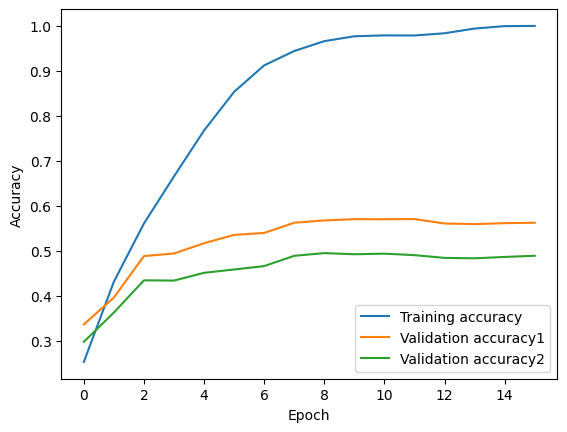

In [56]:
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_acc1, label='Validation accuracy1')
plt.plot(val_acc2, label='Validation accuracy2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

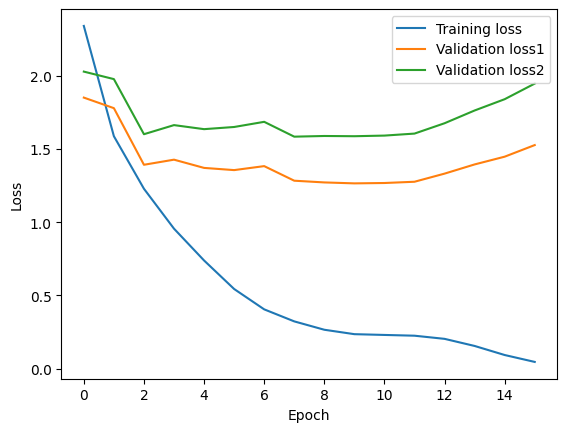

In [57]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses1, label='Validation loss1')
plt.plot(val_losses2, label='Validation loss2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Train the network

You can modify your TestDataset, but you should be mindful to align it with the training dataset and its transformations.

In [64]:
pt_path="/content/gdrive/MyDrive/mldl2/MLDL2_HW/simclr_resnet18_epoch10.pt"
base_encoder = eval(backbone)
pre_model = SimCLR(base_encoder, projection_dim=projection_dim).cuda()
pre_model.load_state_dict(torch.load(pt_path))
pt_path="/content/gdrive/MyDrive/mldl2/MLDL2_HW/self_best_model.pth"
model = LinModel(pre_model.enc, feature_dim=pre_model.feature_dim, n_classes=10)
model.load_state_dict(torch.load(pt_path))
model.to(device)
test_acc = run_epoch(model, val_loader, 90)
print(test_acc)

Test epoch 90, loss: 1.2671, acc: 0.5702: 100%|██████████| 1250/1250 [00:10<00:00, 122.57it/s]

(1.2670931887626649, 0.5702)


In [65]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)

        return image

In [66]:
test_dataset = TestDataset(img_file="./test_data.npy",transform=val_transform2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [67]:
next(iter(test_loader)).size()

torch.Size([8, 3, 32, 32])

## **Do not modify the cell below!!!!**


In [68]:
def test(model, test_loader):
  model.eval()

  ### List to store predictions
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):

          data = data.float().to(device)
          output = model(data)
          ### Get most likely predicted  with argmax
          predicted_labels = torch.argmax(output, dim=1)

          test_predictions.extend(predicted_labels.cpu().tolist())

  return test_predictions

In [69]:
predictions = test(model, test_loader)

100%|██████████| 119/119 [00:00<00:00, 197.43it/s]


In [70]:
### Create CSV file with predictions
saved_path="2019-17577_정지후_self_HW3.csv"
with open(saved_path, "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))